## Lifestyle analysis

#### How step count affects pain_level - part 1
Check the average number of steps taken in the days before a pain_level recording

In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import poisson
from scipy.stats import shapiro, kstest, normaltest, anderson

In [3]:
# Read in filtered data
file_path = 'data/filtered_data.csv'
fdf = pd.read_csv(file_path)
fdf.shape

(26141, 47)

Lifestyle effects variables of interest:
'date', 'userID', 'period', 'pain_level', 'sleep', 'sleep_minutes', 'steps'

In [5]:
# Sort data by userID and date
steps_df = fdf[['ID', 'date', 'userID', 'period', 'pain_level', 'steps']]
steps_df = steps_df.sort_values(by=['userID', 'date'])

steps_df['period'] = steps_df['period'].astype(int)
steps_df['pain_level'] = steps_df['pain_level'].astype(float)
steps_df['date'] = pd.to_datetime(steps_df['date'])

print(len(steps_df))
steps_df.head()

26141


,ID,date,userID,period,pain_level,steps
6,248,2021-05-03,92,0,NaN,15557.0
8,257,2021-05-04,92,0,NaN,6000.0
14,264,2021-05-05,92,0,NaN,2900.0
16,266,2021-05-06,92,0,NaN,5700.0
18,269,2021-05-07,92,0,NaN,14200.0


## Find pain_level and step counts for users with data in both columns

In [7]:
# Functions to aggregate and filter step and pain_level data

def get_step_users(df):
    # Create a list of all users that have entries for step count and pain
    users = 0
    count = 0
    step_users = []
    
    # Iterate over each user_ID to create a list of all user_IDs that have steps counts and pain_level entries
    for user_id in df['userID'].unique():
    
        # Filter the DataFrame for the current user_ID
        user_df = df[df['userID'] == user_id]
       
        user_entries = len(user_df)
        step_entries = len(user_df[(user_df['steps'].notnull())])
        pain_entries = len(user_df[(user_df['pain_level'].notnull())])
        users += 1
        
        if (step_entries >0) & (pain_entries >0):
            step_users.append(user_id)
            count += 1
    return step_users
    
def agg_user_data(df, userID):
    # Get all rows related to this user from the df
    user = df[(df['userID'] == userID)]

    # Aggregate rows with the same date
    user_agg = user.groupby('date').agg({
        'ID': 'first', # keep one ID
        'userID': 'first',  # userID is the same 
        'period': 'max',  # 1 if any entry is 1
        'pain_level': 'max',  # max pain_level column 
        'steps': 'max'  #  max steps value
    }).reset_index()
    return user_agg

def get_steps_prior(df, pain_date, window):
    # For pain_level entries, get the prior day's step count within the window timeframe
    start_date = pain_date - timedelta(days=(window+1))
    end_date = pain_date - timedelta(days=1)
    
    # Filter data from df for window before the given date
    relevant_steps = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]
    steps = relevant_steps['steps'].dropna()  # Remove NaNs
    steps_clean = steps[steps != 0]  # Remove zeros

    if steps_clean.empty:
        return
        
    # Calculate the mean steps
    mean_steps = steps_clean.mean()
    if not math.isnan(mean_steps):
        mean_steps = round(mean_steps, 0)
    
    return mean_steps

def get_steps_pain_rows(df, indices, window):
    
    # Create a new df to store the pain_level, steps_prior rows
    user_steps_pain_df = pd.DataFrame(columns=['ID', 'userID', 'pain_level', 'steps', 'period'])
    
    for i in indices:
        # Get date of pain_level for record with ID i
        pain_date = df[df['ID'] == i]['date']
        pain_date = pain_date.tolist()[0]
    
        pain_level = df[df['ID'] == i]['pain_level']
        pain_level = pain_level.tolist()[0]
        
        # Get the steps prior to this date for the number of days in window and get the mean
        mean_steps = get_steps_prior(df, pain_date, window)

        period = df[df['ID'] == i]['period']
        period = period.tolist()[0]

        userID = df[df['ID'] == i]['userID']
        userID = userID.tolist()[0]

        # Add a new row to steps_pain_df for every entry found
        new_row = pd.DataFrame([[i, userID, pain_level, mean_steps, period]], columns=['ID', 'userID', 'pain_level', 'steps', 'period'])
        new_row_clean = new_row.dropna(how='all')
        
        # Concatenate only if user_steps_pain_clean is not empty
        if not new_row_clean.isna().all().all():
            user_steps_pain_df = pd.concat([user_steps_pain_df, new_row_clean], ignore_index=True)

    return user_steps_pain_df

def extract_steps_pain(df, window):
    # Create a larger df to add the new rows for each user
    all_steps_pain_df = pd.DataFrame(columns=['ID', 'userID', 'pain_level', 'steps', 'period'])

    # Extract the users with step and pain_level counts from the df
    step_users = get_step_users(df)
    
    # Iterate over all the users in stepping_users
    for user in step_users:
        # Get the user entries from df and aggregate it 
        user_agg = agg_user_data(df, user)

        # Filter all entries from aggregated data where a pain_level is not null
        pain_entries = user_agg[(user_agg['pain_level'].notnull())]
        
        # Get the data ID for pain entries
        indices = pain_entries.reset_index()['ID']

        user_steps_pain_df = get_steps_pain_rows(user_agg, indices, window)
        user_steps_pain_clean = user_steps_pain_df.dropna(how='all')

        # Concatenate only if user_steps_pain_clean is not empty
        if not user_steps_pain_clean.empty:
            all_steps_pain_df = pd.concat([all_steps_pain_df, user_steps_pain_clean], ignore_index=True)
        
    return all_steps_pain_df


In [8]:
# For sample use 'userID' == 928
#agg_user_df = agg_user_data(ldf, 928)
#print(agg_user_df)

#df_928 = fdf[(fdf['userID'] == 928)]
#extract_steps_pain(df_928, 3)  

In [ ]:
# Extract steps vs pain data from df
days = 3 # Number of days before pain_level record
steps_pain_df = extract_steps_pain(steps_df, days)
steps_pain_df.head()

In [10]:
print(steps_pain_df.isna().any())
steps_pain_df = steps_pain_df.dropna()

ID            False
userID        False
pain_level    False
steps          True
period        False
dtype: bool


In [11]:
steps_pain_df.head()

,ID,userID,pain_level,steps,period
2,8269,113,2.0,19000.0,1
3,8368,113,8.0,14500.0,1
4,8367,113,4.0,14667.0,1
10,10943,113,5.0,12500.0,1
14,11000,113,2.0,11000.0,1


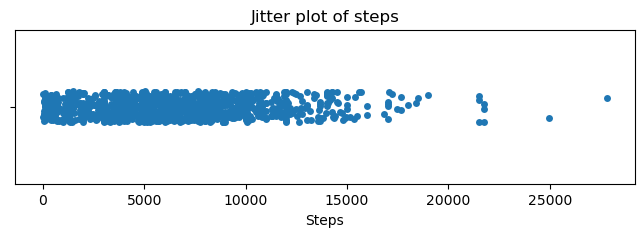

In [12]:
plt.figure(figsize=(8, 2))
sns.stripplot(x='steps', data=steps_pain_df)
plt.title('Jitter plot of steps')
plt.xlabel('Steps')
plt.show()

- 100,000 steps ~ 76.2 kilometers
- 50,000 steps ~ 38 kilometers
- 30,000 steps ~ 23 kilometers

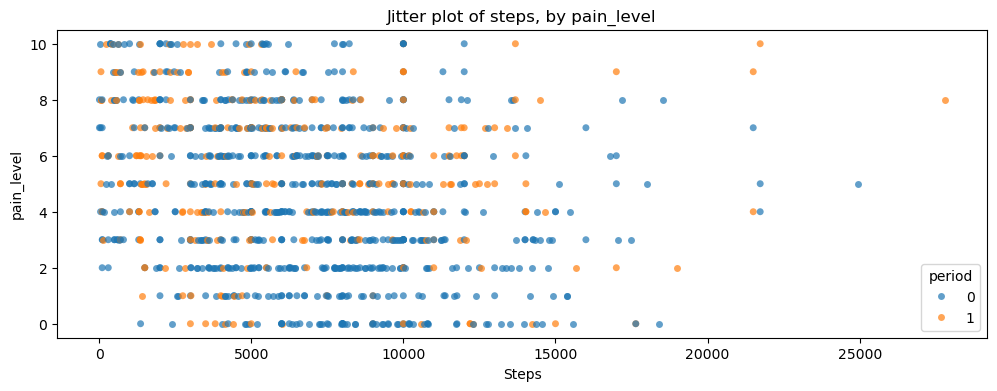

In [14]:
plt.figure(figsize=(12, 4))
sns.stripplot(x='steps', y='pain_level', data=steps_pain_df, jitter=0.5, hue="period", alpha=0.7, native_scale=True)
plt.title('Jitter plot of steps, by pain_level')
plt.xlabel('Steps')
plt.show()

In [15]:
steps_pain_df['userID'].value_counts().sort_index()

userID
113     55
118      1
446      3
470      1
895      1
        ..
7706     2
7778     1
7946     1
8255     2
8258     3
Name: count, Length: 242, dtype: int64

In [16]:
# Aggregate data to get the number of entries per user
step_entry_cnt = steps_pain_df['userID'].value_counts()
step_entry_cnt = step_entry_cnt.reset_index()
step_entry_cnt = step_entry_cnt.sort_values(by='count', ascending=False)
step_entry_cnt.head(10)

,userID,count
0,113,55
1,3038,47
2,6153,32
3,4049,28
4,5688,27
5,2077,25
6,6175,22
7,2038,21
8,5324,20
11,928,19


In [17]:
# Number of users
print("Number of users:", len(steps_pain_df['userID'].unique()))
print("Number of entries:", len(steps_pain_df))

Number of users: 242
Number of entries: 1106


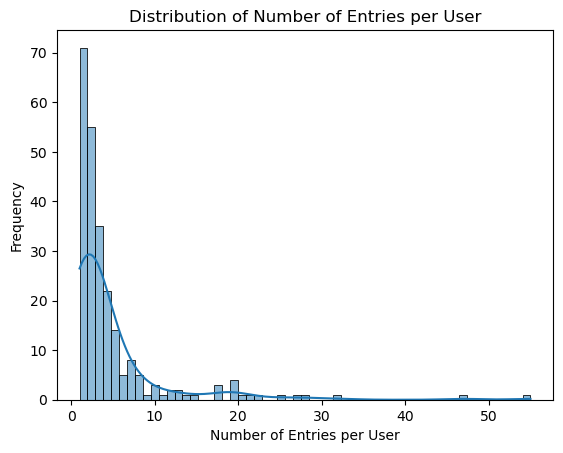

In [18]:
# Visualize the distribution
sns.histplot(step_entry_cnt['count'], kde=True)
plt.xlabel('Number of Entries per User')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Entries per User')
plt.savefig('fig/dist_step_entries.png', dpi=300)  
plt.show()

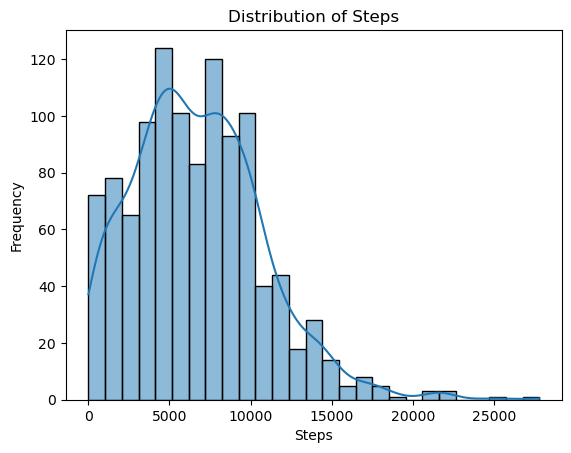

Skewness: 0.7479467853830508
Kurtosis: 1.2150568660026373
Shapiro-Wilk Statistic: 0.9647522612637593, p-value: 1.0095673270017314e-15


In [19]:
# Distribution plot for 'steps'
sns.histplot(steps_pain_df['steps'], kde=True)
plt.title('Distribution of Steps')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.show()

# Calculate skewness and kurtosis
skewness = stats.skew(steps_pain_df['steps'])
print(f"Skewness: {skewness}")
kurtosis = stats.kurtosis(steps_pain_df['steps'])
print(f"Kurtosis: {kurtosis}")

# Shapiro-Wilk test
stat, p_value = shapiro(steps_pain_df['steps'])
print(f"Shapiro-Wilk Statistic: {stat}, p-value: {p_value}")

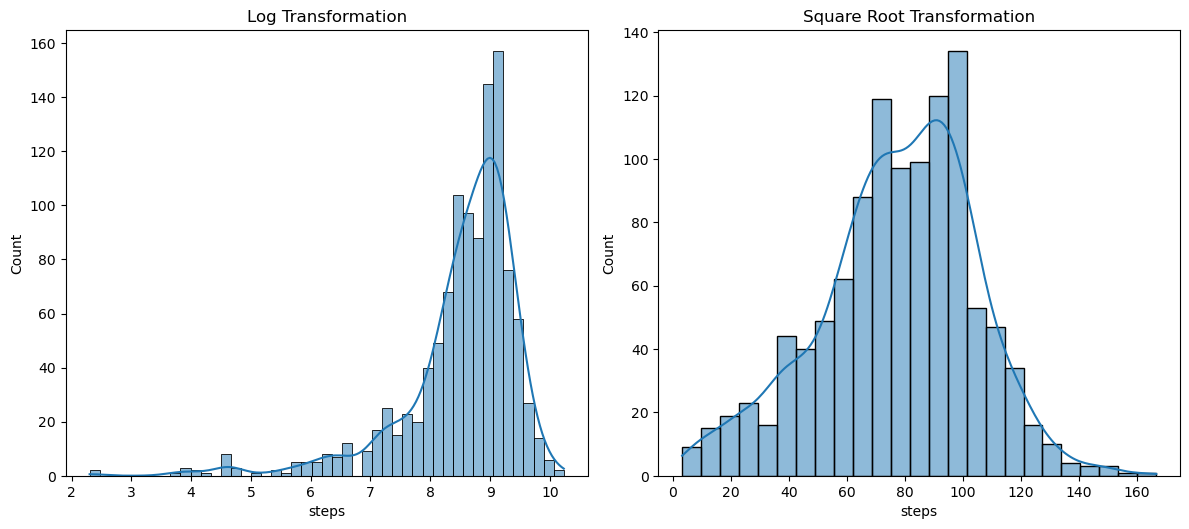

Shapiro-Wilk Test for Normality
Original: ShapiroResult(statistic=0.9647522612637593, pvalue=1.0095673270017314e-15)
Log Transformation: ShapiroResult(statistic=0.8092917525153231, pvalue=3.309068696859022e-34)
Square Root Transformation: ShapiroResult(statistic=0.9861021104804167, pvalue=9.220471451861748e-09)


In [20]:
steps = steps_pain_df['steps']
log_steps = np.log(steps) # Log Transformation
sqrt_steps = np.sqrt(steps) # Square Root Transformation

# Plot Histograms
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
sns.histplot(log_steps, kde=True)
plt.title('Log Transformation')
plt.subplot(2, 2, 2)
sns.histplot(sqrt_steps, kde=True)
plt.title('Square Root Transformation')
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test for Normality
print("Shapiro-Wilk Test for Normality")
print("Original:", shapiro(steps))
print("Log Transformation:", shapiro(log_steps))
print("Square Root Transformation:", shapiro(sqrt_steps))

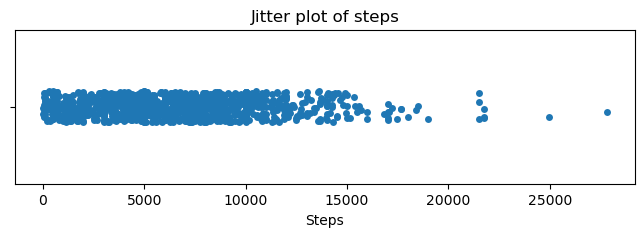

In [21]:
plt.figure(figsize=(8, 2))
sns.stripplot(x='steps', data=steps_pain_df)
plt.title('Jitter plot of steps')
plt.xlabel('Steps')
plt.show()

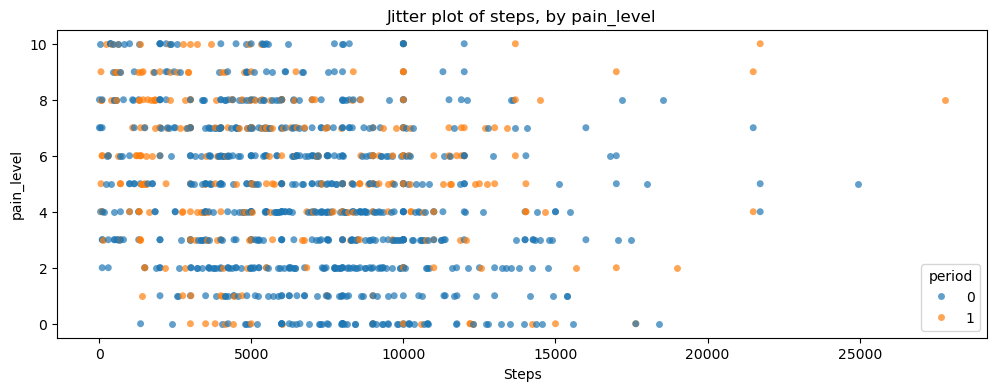

In [22]:
plt.figure(figsize=(12, 4))
sns.stripplot(x='steps', y='pain_level', data=steps_pain_df, jitter=0.5, hue="period", alpha=0.7, native_scale=True)
plt.title('Jitter plot of steps, by pain_level')
plt.xlabel('Steps')
plt.show()

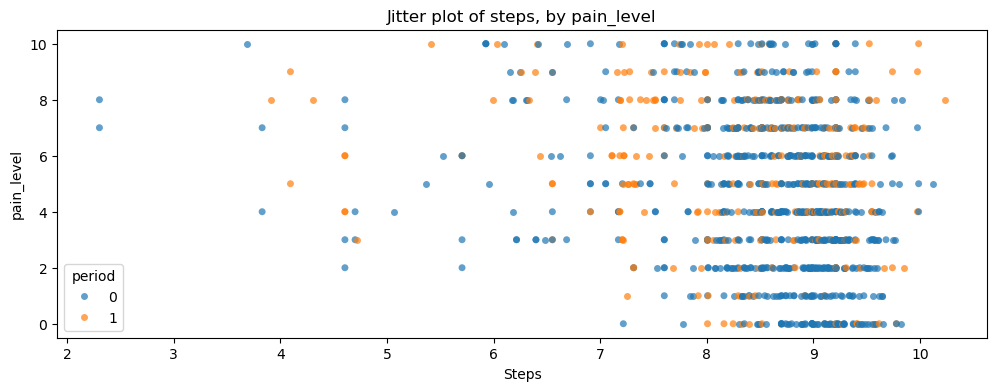

In [23]:
# Log steps
steps_pain_df['log_steps'] = np.log(steps_pain_df['steps'])

plt.figure(figsize=(12, 4))
sns.stripplot(x='log_steps', y='pain_level', data=steps_pain_df, jitter=0.5, hue="period", alpha=0.7, native_scale=True)
plt.title('Jitter plot of steps, by pain_level')
plt.xlabel('Steps')
plt.show()

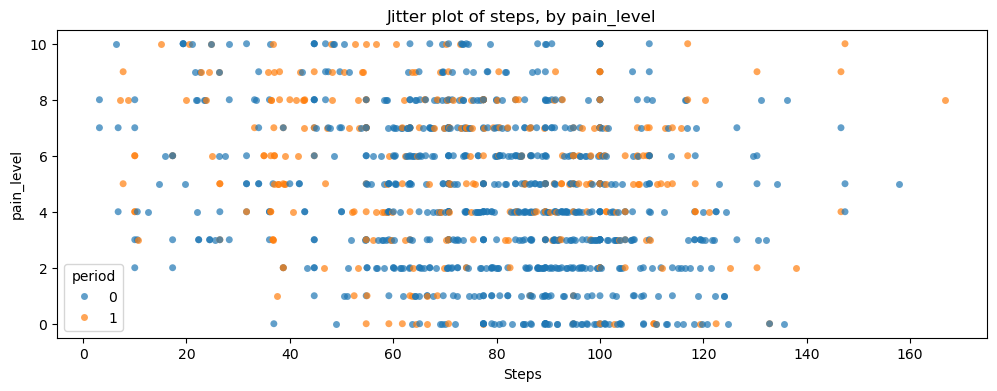

In [24]:
# Square Root Transformation
steps_pain_df['sqrt_steps'] = np.sqrt(steps_pain_df['steps'])

plt.figure(figsize=(12, 4))
sns.stripplot(x='sqrt_steps', y='pain_level', data=steps_pain_df, jitter=0.5, hue="period", alpha=0.7, native_scale=True)
plt.title('Jitter plot of steps, by pain_level')
plt.xlabel('Steps')
plt.show()

In [25]:
# Mixed Linear model
linear_model1 = smf.mixedlm("pain_level ~ steps", steps_pain_df, groups=steps_pain_df["userID"])
linear_result1 = linear_model1.fit()

# Results
print(linear_result1.summary())
print(f"Coefficient for steps: {linear_result1.params['steps']:.10f}")
print(f"Standard error: {linear_result1.bse['steps']:.10f}")

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pain_level
No. Observations: 1106    Method:             REML      
No. Groups:       242     Scale:              3.3959    
Min. group size:  1       Log-Likelihood:     -2432.2089
Max. group size:  55      Converged:          Yes       
Mean group size:  4.6                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      5.533    0.204 27.177 0.000  5.134  5.932
steps         -0.000    0.000 -3.826 0.000 -0.000 -0.000
Group Var      3.788    0.283                           

Coefficient for steps: -0.0000871701
Standard error: 0.0000227826


In [26]:
# Mixed Linear model steps + period
linear_modelt2 = smf.mixedlm("pain_level ~ steps + period", steps_pain_df, groups=steps_pain_df["userID"])
linear_result2 = linear_modelt2.fit()

# Results
print(linear_result2.summary())
print(f"Coefficient for steps: {linear_result2.params['steps']:.10f}")
print(f"Standard error: {linear_result2.bse['steps']:.10f}")

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pain_level
No. Observations: 1106    Method:             REML      
No. Groups:       242     Scale:              3.3097    
Min. group size:  1       Log-Likelihood:     -2419.7408
Max. group size:  55      Converged:          Yes       
Mean group size:  4.6                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      5.292    0.207 25.571 0.000  4.887  5.698
period[T.1]    0.830    0.160  5.204 0.000  0.518  1.143
steps         -0.000    0.000 -3.821 0.000 -0.000 -0.000
Group Var      3.748    0.284                           

Coefficient for steps: -0.0000860658
Standard error: 0.0000225250


In [27]:
# Mixed Linear model Log Transformation steps
log_model1 = smf.mixedlm("pain_level ~ log_steps", steps_pain_df, groups=steps_pain_df["userID"])
log_results1 = log_model1.fit()

# Results
print(log_results1.summary())
print(f"Coefficient for steps: {log_results1.params['log_steps']:.10f}")
print(f"Standard error: {log_results1.bse['log_steps']:.10f}")

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pain_level
No. Observations: 1106    Method:             REML      
No. Groups:       242     Scale:              3.3894    
Min. group size:  1       Log-Likelihood:     -2422.3968
Max. group size:  55      Converged:          Yes       
Mean group size:  4.6                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      8.303    0.800 10.380 0.000  6.735  9.870
log_steps     -0.396    0.094 -4.206 0.000 -0.580 -0.211
Group Var      3.762    0.282                           

Coefficient for steps: -0.3956630995
Standard error: 0.0940814035


In [28]:
# Mixed Linear model Log Transformation steps + period
log_model2 = smf.mixedlm("pain_level ~ log_steps + period", steps_pain_df, groups=steps_pain_df["userID"])
log_results2 = log_model2.fit()

# Results
print(log_results2.summary())
print(f"Coefficient for steps: {log_results2.params['log_steps']:.10f}")
print(f"Standard error: {log_results2.bse['log_steps']:.10f}")

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pain_level
No. Observations: 1106    Method:             REML      
No. Groups:       242     Scale:              3.3105    
Min. group size:  1       Log-Likelihood:     -2410.8359
Max. group size:  55      Converged:          Yes       
Mean group size:  4.6                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      7.869    0.797  9.877 0.000  6.307  9.430
period[T.1]    0.802    0.160  5.022 0.000  0.489  1.115
log_steps     -0.371    0.093 -3.975 0.000 -0.554 -0.188
Group Var      3.719    0.283                           

Coefficient for steps: -0.3707791567
Standard error: 0.0932860940


In [30]:
log_results2.summary().as_latex()

'\\begin{table}\n\\caption{Mixed Linear Model Regression Results}\n\\label{}\n\\begin{center}\n\\begin{tabular}{llll}\n\\hline\nModel:            & MixedLM & Dependent Variable: & pain\\_level  \\\\\nNo. Observations: & 1106    & Method:             & REML         \\\\\nNo. Groups:       & 242     & Scale:              & 3.3105       \\\\\nMin. group size:  & 1       & Log-Likelihood:     & -2410.8359   \\\\\nMax. group size:  & 55      & Converged:          & Yes          \\\\\nMean group size:  & 4.6     &                     &              \\\\\n\\hline\n\\end{tabular}\n\\end{center}\n\n\\begin{center}\n\\begin{tabular}{lrrrrrr}\n\\hline\n            &  Coef. & Std.Err. &      z & P$> |$z$|$ & [0.025 & 0.975]  \\\\\n\\hline\nIntercept   &  7.869 &    0.797 &  9.877 &       0.000 &  6.307 &  9.430  \\\\\nperiod[T.1] &  0.802 &    0.160 &  5.022 &       0.000 &  0.489 &  1.115  \\\\\nlog\\_steps  & -0.371 &    0.093 & -3.975 &       0.000 & -0.554 & -0.188  \\\\\nGroup Var   &  3.719 

# Intrepretation

Log-transformed model (log_steps):
Multiplicative: For each unit increase in log_steps, pain_level decreases by 0.371 units.
Increase steps from 1,000 to 10,000 (log(10)≈2.3) Pain change≈> −0.371×2.3≈ −0.85

